In [420]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import csv
import io
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error as mae

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [421]:
num_lags = 3
timesteps = 6
setting = 'FNN_monthly_R2_'+str(timesteps)
title = 'FNN (ReLU, 1 Hidden Layer) Model Performance for Monthly Data: '+str(timesteps)+' Time Step'
if timesteps != 1:
    title += 's'

In [422]:
# read in data
data_type = 'average' #'min', 'max'
df = pd.read_csv('j17_monthly.csv')
pd.DataFrame.reset_index(df, drop=True)
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores['year'] = df['year']
z_scores['month'] = df['month']
z_scores['level_'+data_type] = df['level_'+data_type]
z_scores['Z Scores'], mean, std = z_score_calc(df,'level_'+data_type) # noramlization speeds up learning and leads to faster convergence
z_scores.to_csv("j17wl_monthly_z_scores.csv") 
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
# prepare data
cols = []
for i in range(num_lags):
    cols.append(i+1)
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
#ds_x = np.flip(ds_x,axis=0)
#ds_y = np.flip(ds_y,axis=0)
#print(ds_x)
#print(ds_y)
# ~80% training
ds_train_x = ds_x[:int(0.8*len(ds_x))]
ds_train_y = ds_y[:int(0.8*len(ds_x))]
# ~20% testing
ds_test_x = ds_x[int(0.8*len(ds_x)):]
ds_test_y = ds_y[int(0.8*len(ds_x)):]

In [423]:
# build NN
epochs = 100
batch_size = 100
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='relu', input_dim=num_lags))
#model.add(keras.layers.Dense(10, activation='relu'))
#model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(1)) # output layer; gives a 1D output
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(ds_train_x, ds_train_y, batch_size=batch_size, epochs=epochs, verbose=3)
# apply to predictions
predictions = model.predict(ds_test_x)
r = []
for i in predictions:
    r.append(i[0])
result = np.array(r)
predicted_vals = result * std + mean
true_vals = ds_test_y * std + mean
diff = true_vals - predicted_vals
count_err = 0
count = 0
for i in diff:
    if abs(i) <= 1.0:
      count += 1
corr_m = np.corrcoef(predicted_vals, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")
mse = np.square(diff).mean()
print('MSE = ' + str(mse))
mae = np.mean(np.abs(diff))
print('MAE = ' + str(mae))

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [424]:
#plt.plot(history.history['mean_absolute_error'])

In [425]:
tf.keras.models.save_model(model,'Saved Models/'+setting)

INFO:tensorflow:Assets written to: Saved Models/FNN_monthly_R2_6/assets


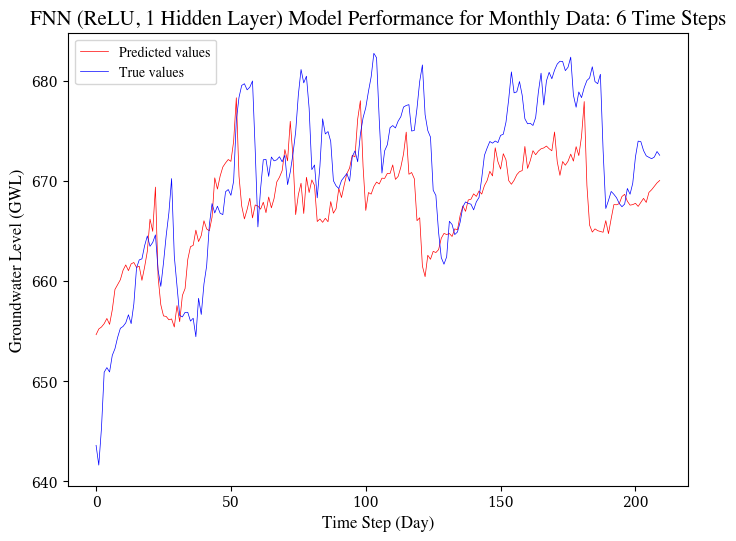

In [426]:
plt.rcParams['font.family'] = 'serif'
f='Times'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_serif.png', dpi=300)
plt.show()

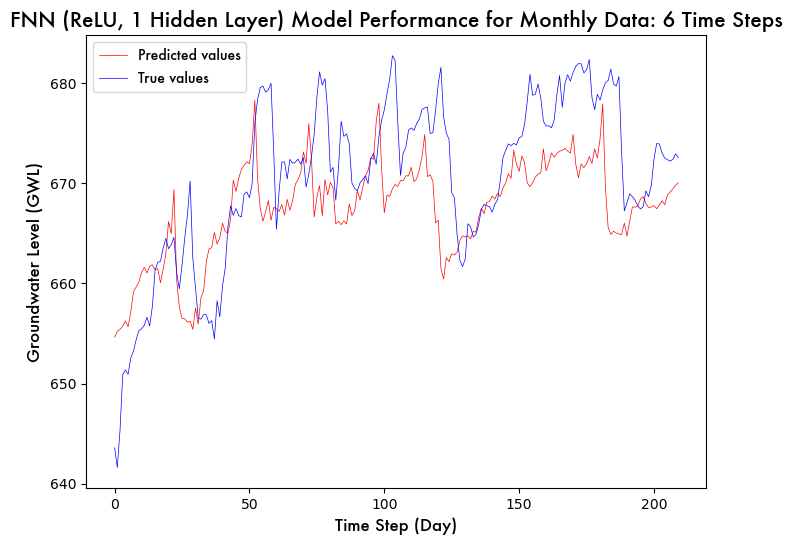

In [427]:
plt.rcParams['font.family'] = 'sans-serif'
f='Futura'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_sans-serif.png', dpi=300)
plt.show()

In [428]:
print('R2 = ' + str(r2*100) + "%")
print('MSE = ' + str(mse))
print('MAE = ' + str(mae))

R2 = 50.430443748452305%
MSE = 44.523337850784586
MAE = 5.244824170859766
